# Machine Learning Engineer Nanodegree
## Capstone Project - Starbucks app data

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from lib.utils import analyse_cat_var, analyse_num_var

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv('data/journey.csv', parse_dates=['member_on'])

# Offer received and never viewed have no interest for us, so we drop them
df = df.loc[(df['offer_type'] == 'transaction') | (df['time_viewed'].isnull() == False)]

df['time'] = df['time_viewed']
df.loc[df['offer_type'] == 'transaction', 'time'] = df['time_transaction']

df.sort_values(['person', 'time', 'offer_id'], inplace=True)

print(df.shape)
df.head()

(150435, 22)


,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,pot_reward,difficulty,duration,offer_type,web,email,mobile,social,channels_num,gender,age,income,member_on
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.0,168.0,192.0,NaN,NaN,NaN,NaN,0.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,3.0,M,33,72000.0,2017-04-21
1,0009655768c64bdeb2e877511632db8f,NaN,228.0,NaN,NaN,NaN,228.0,22.16,NaN,NaN,NaN,NaN,transaction,NaN,NaN,NaN,NaN,NaN,M,33,72000.0,2017-04-21
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.0,336.0,372.0,NaN,NaN,NaN,NaN,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0,3.0,M,33,72000.0,2017-04-21
4,0009655768c64bdeb2e877511632db8f,NaN,414.0,NaN,NaN,NaN,414.0,8.57,NaN,NaN,NaN,NaN,transaction,NaN,NaN,NaN,NaN,NaN,M,33,72000.0,2017-04-21
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456.0,408.0,456.0,NaN,NaN,NaN,NaN,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,4.0,M,33,72000.0,2017-04-21


# Part 2 - Feature Engineering

## Conversion Rate

Our goal is to predict the right type of offer for each customer, in order to grow the **Conversion Rate** (the percentage of offers *completed* on all offers). What's the actual CR? We calculate it as **benchmark** of our model.

We have to keep in mind that:
- *Informational* offers do not have a real conversion, nor a *completed offer* record. In this case, we exclude them to have a more precise benchmark.
- Only *viewed* offers can be considered, since we do not have a real *conversion* if the customer never saw the offer.

In [4]:
# Create some help flags
tmp = df.loc[:, ['offer_type', 'time_viewed', 'time_completed']]

# Flag offer viewed
tmp['flg_viewed'] = 0
tmp.loc[(tmp['offer_type'].isin(['bogo', 'discount'])) & (tmp['time_viewed'].isnull() == False), 'flg_viewed'] = 1


# Flag conversion
tmp['flg_conv'] = 0
tmp.loc[
    (tmp['offer_type'].isin(['bogo', 'discount'])) & (tmp['time_viewed'].isnull() == False) & (df['time_completed'].isnull() == False),
    'flg_conv'
] = 1

num = sum(tmp['flg_conv'])
den = sum(tmp['flg_viewed'])
print(f'There are {den} viewed offers.')
print(f'There are {num} completed offers.')
print(f'\n\nThe Conversion Rate is {round((num / den) * 100, 2)}%; it is divided as follows')


display(tmp.loc[tmp['flg_viewed'] == 1].groupby('offer_type').agg({'flg_conv': 'mean'}))

del tmp

There are 39725 viewed offers.
There are 22816 completed offers.


The Conversion Rate is 57.43%; it is divided as follows


,flg_conv
offer_type,
bogo,0.504744
discount,0.657340


We want to further analyse the idea of a **conversion** with an **informational** offer. There is no clear record on data, but maybe the message on the app made the customer buy something. We cannot be sure, but we can approximate this phenomenon if:
- the next record right after an informational offer is a **transaction**
- the transaction happened in a short period after the informational offer **view**.

In [5]:
# Let's make a copy of the dataset
inf = df.loc[(df['time_viewed'].isnull() == False) | (df['time_transaction'].isnull() == False),
             ['person', 'offer_id', 'offer_type', 'time_viewed', 'time_transaction']]
inf['time'] = inf['time_viewed']
inf.loc[inf['time'].isnull(), 'time'] = inf['time_transaction']
inf.sort_values(['person', 'time', 'offer_id'], inplace=True)

# Now we shift the info of the subsequent record
inf['sub_offer_type'] = inf['offer_type'].shift(-1)
inf['sub_time'] = inf['time'].shift(-1)
# If the next record is relative to another customer, we put a missing
inf.loc[inf['person'].shift(-1) != inf['person'], ['sub_offer_type', 'sub_time']] = ['', np.nan]

# Finally we calculate the time difference
inf['time_diff_with_sub'] = inf['sub_time'] - inf['time_viewed']

What's the distribution of the time shift on the interested records?

count    6790.000000
mean       43.230928
std        56.776195
min         0.000000
25%         6.000000
50%        24.000000
75%        54.000000
max       552.000000
Name: time_diff_with_sub, dtype: float64

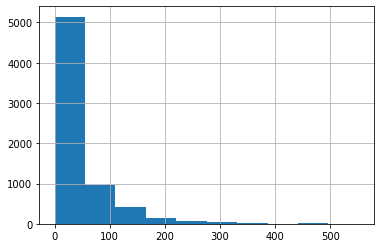

In [6]:
display(inf.loc[(inf['offer_type'] == 'informational') & (inf['sub_offer_type'] == 'transaction'), 'time_diff_with_sub'].describe())

inf.loc[(inf['offer_type'] == 'informational') & (inf['sub_offer_type'] == 'transaction'), 'time_diff_with_sub'].hist()
plt.show()

The median "response time" is 24 hours: what is the CR if we set this value as threshold?

In [7]:
threshold = 24

num = sum((inf['offer_type'] == 'informational') & (inf['sub_offer_type'] == 'transaction') & (inf['time_diff_with_sub'] <= threshold))
den = sum(inf['offer_type'] == 'informational')
print(f'There are {den} informational offers.')
print(f'There are {num} conversions with a response time of {threshold} hours.')
print(f'The Conversion Rate is {round((num / den) * 100, 2)}%.')

There are 9360 informational offers.
There are 3634 conversions with a response time of 24 hours.
The Conversion Rate is 38.82%.


## Target features

After studying the CR, we can build the target of our analysis. We will create 3 different columns, one for each type of offer, all 0/1 flags (where 1 is conversion, 0 is not). 

In [8]:
# BOGO target
df.loc[(df['time_viewed'].isnull() == False) & (df['offer_type'] == 'bogo'), 'bogo'] = 0
df.loc[(df['time_viewed'].isnull() == False) & (df['offer_type'] == 'bogo') & (df['time_completed'].isnull() == False), 'bogo'] = 1

# Discount target
df.loc[(df['time_viewed'].isnull() == False) & (df['offer_type'] == 'discount'), 'discount'] = 0
df.loc[(df['time_viewed'].isnull() == False) & (df['offer_type'] == 'discount') & (df['time_completed'].isnull() == False), 'discount'] = 1

In [9]:
# For the informational target, we use the previously created inf dataset, define the logistic, then merge with df
inf.loc[inf['offer_type'] == 'informational', 'info'] = 0
inf.loc[(inf['offer_type'] == 'informational') & (inf['sub_offer_type'] == 'transaction') & (inf['time_diff_with_sub'] <= threshold), 'info'] = 1

df = pd.merge(df,
              inf.loc[inf['info'].isnull() == False, ['person', 'offer_id', 'time_viewed', 'info', 'sub_time']],
              how='left', on=['person', 'offer_id', 'time_viewed'])

# Let's force time_completed equal to time_transaction for informational data
df.loc[df['info'] == 1, 'time_completed'] = df['sub_time']
df.loc[df['info'] == 1, 'time_transaction'] = df['sub_time']
df.drop('sub_time', 1, inplace=True)

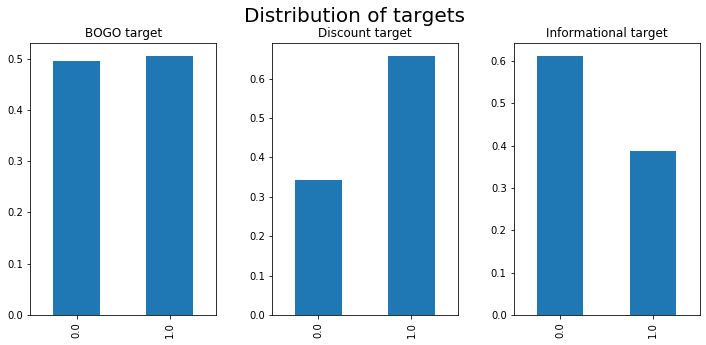

There are:
- 21605 records for BOGO target
- 18120 records for Discount target
- 9360 records for Informational target


In [10]:
plt.subplots(1, 3, figsize=(12, 5))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.suptitle('Distribution of targets', size=20)

plt.subplot(131)
plt.title('BOGO target')
df['bogo'].value_counts(1, sort=False).plot(kind='bar')

plt.subplot(132)
plt.title('Discount target')
df['discount'].value_counts(1, sort=False).plot(kind='bar')

plt.subplot(133)
plt.title('Informational target')
df['info'].value_counts(1, sort=False).plot(kind='bar')

plt.show()

print('There are:')
print('- {} records for BOGO target'.format(sum(df['bogo'].isnull() == False)))
print('- {} records for Discount target'.format(sum(df['discount'].isnull() == False)))
print('- {} records for Informational target'.format(sum(df['info'].isnull() == False)))

## Customers features

In [11]:
customers = df[['person', 'gender', 'age', 'income', 'member_on']].drop_duplicates()

display(customers.describe(include='all').transpose())

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
person,14815,14815,d7e3b10e486741ec81540edbf7d77c7c,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,14815,3,M,8477,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,14815,NaN,NaN,NaN,NaT,NaT,54.3931,17.3866,18,42,55,66,101
income,14815,NaN,NaN,NaN,NaT,NaT,65397.8,21598.6,30000,49000,64000,80000,120000
member_on,14815,1707,2017-08-19 00:00:00,39,2013-07-29,2018-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN


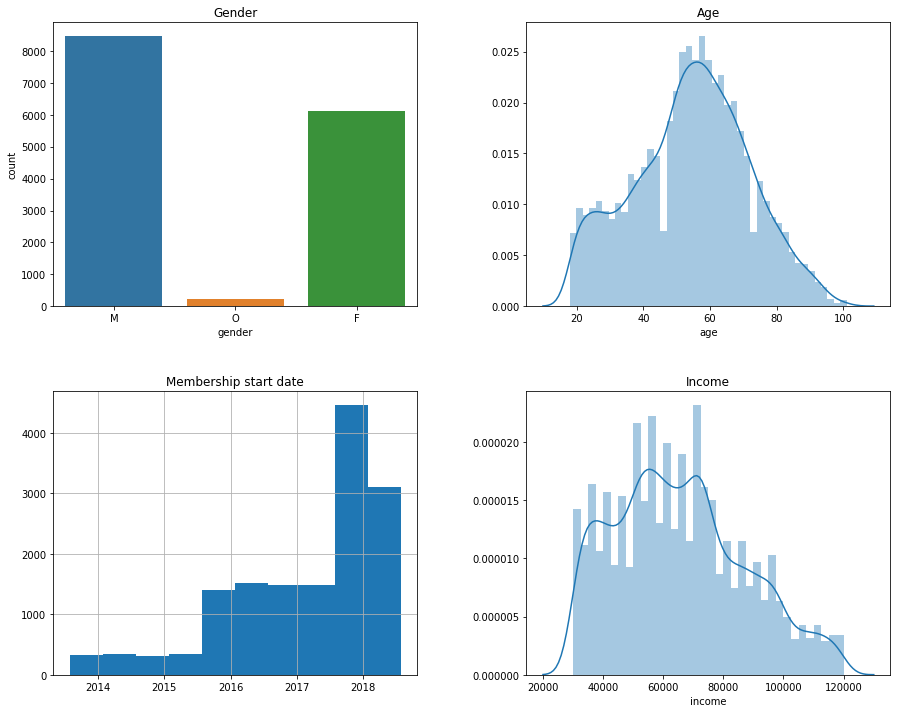


Membership start dates range from 2013-07-29 to 2018-07-26.



In [12]:
plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(221)
plt.title('Gender')
sns.countplot(x='gender', data=customers)

plt.subplot(222)
plt.title('Age')
sns.distplot(customers['age'])

plt.subplot(223)
plt.title('Membership start date')
customers['member_on'].hist()

plt.subplot(224)
plt.title('Income')
sns.distplot(customers['income'])

plt.show()


print('\nMembership start dates range from {} to {}.\n'.format(
    customers['member_on'].min().strftime('%Y-%m-%d'), customers['member_on'].max().strftime('%Y-%m-%d')
))

Some considerations:
- there is a third gender **O**, with very few records
- *age* has quite a normal distribution, while *income* has continuous spikes and has an irregular distribution
- the customers are quite new members, since the memberships are concentrated from the last part of 2017 onwards

### Feat Eng level 1

We can build some new features:
- *Time* feature is registered from a specific *T0*, which is unknown: we can suppose that it's the nearest month after the membership range, so 2018-08-01. We can create a feature **member_from** that register the number of months of membership.
- We can transform *time_viewed* in **Day** dividing by 24. We could not know if day 1 is Monday or Friday, but the model could find some relationship.

In [13]:
from datetime import datetime

def diff_month(d1, d2):
    return (d2.year - d1.year) * 12 + d2.month - d1.month

In [14]:
# Transform hours in days
df['day'] = np.floor(df['time_viewed'] / 24)

# Day of week
df['dow'] = df['day'].mod(7)

# Member from
df['member_from'] = df.apply(lambda x: diff_month(x['member_on'], datetime(2018, 8, 1)), 1)
df.head()

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,pot_reward,difficulty,duration,offer_type,web,email,mobile,social,channels_num,gender,age,income,member_on,bogo,discount,info,day,dow,member_from
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.0,168.0,192.0,NaN,NaN,NaN,NaN,0.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,3.0,M,33,72000.0,2017-04-21,NaN,NaN,0.0,8.0,1.0,16
1,0009655768c64bdeb2e877511632db8f,NaN,228.0,NaN,NaN,NaN,228.0,22.16,NaN,NaN,NaN,NaN,transaction,NaN,NaN,NaN,NaN,NaN,M,33,72000.0,2017-04-21,NaN,NaN,NaN,NaN,NaN,16
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.0,336.0,372.0,NaN,NaN,NaN,NaN,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0,3.0,M,33,72000.0,2017-04-21,NaN,NaN,0.0,15.0,1.0,16
3,0009655768c64bdeb2e877511632db8f,NaN,414.0,NaN,NaN,NaN,414.0,8.57,NaN,NaN,NaN,NaN,transaction,NaN,NaN,NaN,NaN,NaN,M,33,72000.0,2017-04-21,NaN,NaN,NaN,NaN,NaN,16
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456.0,408.0,456.0,NaN,NaN,NaN,NaN,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,4.0,M,33,72000.0,2017-04-21,0.0,NaN,NaN,19.0,5.0,16


How are thes variables distributed?

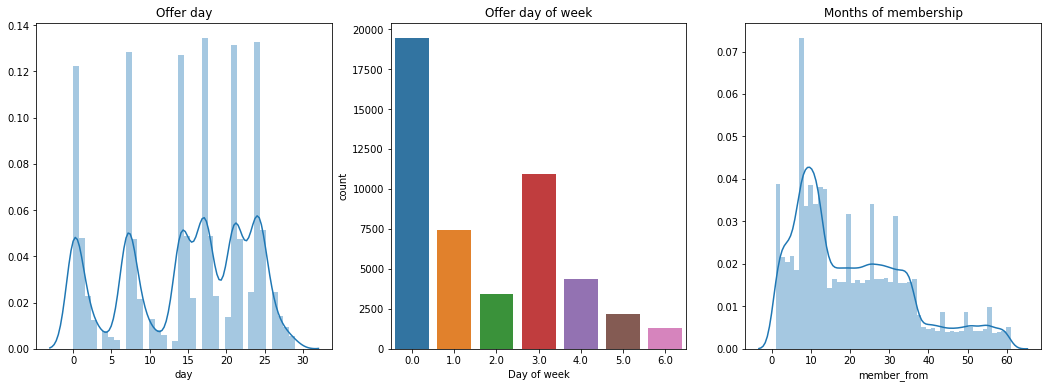

In [15]:
plt.subplots(1, 3, figsize=(18, 6))

plt.subplot(131)
plt.title('Offer day')
sns.distplot(df['day'].dropna())

plt.subplot(132)
plt.title('Offer day of week')
sns.countplot(df['dow'].dropna())
plt.xlabel('Day of week')

plt.subplot(133)
plt.title('Months of membership')
sns.distplot(df['member_from'].dropna())

plt.show()

There are a lot of potential **rolling features**, looking at the previous data about the customer, such as:
- number / amount of past transactions
- number of offers completed
- total amount of rewards
- medium time between offer reception and view / offer view and completion

I decided not to calculate them for the **cold start** issue: if we develop a model that highly depends on these features, it will hardly understand the propension on new customers, which made only few transactions.

### Feat Eng level 2

In [16]:
df.reset_index(drop=True, inplace=True)
df['n_transactions'] = 0
df['avg_transctions'] = 0
df['is_transaction'] = 0
df.loc[df['time_transaction'].isnull() == False, 'is_transaction'] = 1
df['is_completed'] = 0
df.loc[df['time_completed'].isnull() == False, 'is_completed'] = 1
df['n_offers_completed'] = 0
df['n_offers_viewed'] = 0
df['avg_reward'] = 0
df['reception_to_view'] = df['time_viewed'] - df['time_received']
df['view_to_completion'] = df['time_completed'] - df['time_viewed']
df['reception_to_view_avg'] = 0
df['view_to_completion_avg'] = 0

df['prev_person'] = df['person'].shift(1)
for i, row in df.iterrows():
    if i % 10000 == 0:
        print(i)
    if row['person'] == row['prev_person']:
        df.loc[i, 'n_offers_viewed'] = df.loc[i-1, 'n_offers_viewed'] + (0 if df.loc[i-1, 'offer_type'] == 'transaction' else 1)
        df.loc[i, 'n_offers_completed'] = df.loc[i-1, 'n_offers_completed'] + df.loc[i-1, 'is_completed']
        df.loc[i, 'reception_to_view_avg'] = np.nansum((df.loc[i-1, 'reception_to_view_avg'], df.loc[i-1, 'reception_to_view']))
        df.loc[i, 'view_to_completion_avg'] = np.nansum((df.loc[i-1, 'view_to_completion_avg'], df.loc[i-1, 'view_to_completion']))
        df.loc[i, 'n_transactions'] = df.loc[i-1, 'n_transactions'] + df.loc[i-1, 'is_transaction']
        df.loc[i, 'avg_transctions'] = df.loc[i-1, 'avg_transctions'] + (0 if df.loc[i-1, 'is_transaction'] == 0 else df.loc[i-1, 'amount'])
        df.loc[i, 'avg_reward'] = np.nansum((df.loc[i-1, 'avg_reward'], df.loc[i-1, 'reward']))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


In [17]:
df['reception_to_view_avg'] /= df['n_offers_viewed']
df['view_to_completion_avg'] /= df['n_offers_completed']
df['avg_transctions'] /= df['n_transactions']
df['reception_to_view_avg'].fillna(0, inplace=True)
df['view_to_completion_avg'].fillna(0, inplace=True)
df['avg_transctions'].fillna(0, inplace=True)

In [18]:
df.tail(20)

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,pot_reward,difficulty,duration,offer_type,web,email,mobile,social,channels_num,gender,age,income,member_on,bogo,discount,info,day,dow,member_from,n_transactions,avg_transctions,is_transaction,is_completed,n_offers_completed,n_offers_viewed,avg_reward,reception_to_view,view_to_completion,reception_to_view_avg,view_to_completion_avg,prev_person
150415,fffad4f4828548d1b5583907f2e9906b,NaN,558.0,NaN,NaN,NaN,558.0,7.97,NaN,NaN,NaN,NaN,transaction,NaN,NaN,NaN,NaN,NaN,M,34,34000.0,2017-01-23,NaN,NaN,NaN,NaN,NaN,19,9,6.980000,1,0,2,3,10.0,NaN,NaN,36.0,18.0,fffad4f4828548d1b5583907f2e9906b
150416,fffad4f4828548d1b5583907f2e9906b,NaN,588.0,NaN,NaN,NaN,588.0,10.98,NaN,NaN,NaN,NaN,transaction,NaN,NaN,NaN,NaN,NaN,M,34,34000.0,2017-01-23,NaN,NaN,NaN,NaN,NaN,19,10,7.079000,1,0,2,3,10.0,NaN,NaN,36.0,18.0,fffad4f4828548d1b5583907f2e9906b
150417,fffad4f4828548d1b5583907f2e9906b,9b98b8c7a33c4b65b9aebfe6a799e6d9,666.0,576.0,666.0,NaN,NaN,NaN,NaN,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,3.0,M,34,34000.0,2017-01-23,0.0,NaN,NaN,27.0,6.0,19,11,7.433636,0,0,2,3,10.0,90.0,NaN,36.0,18.0,fffad4f4828548d1b5583907f2e9906b
150418,fffad4f4828548d1b5583907f2e9906b,NaN,678.0,NaN,NaN,NaN,678.0,7.06,NaN,NaN,NaN,NaN,transaction,NaN,NaN,NaN,NaN,NaN,M,34,34000.0,2017-01-23,NaN,NaN,NaN,NaN,NaN,19,11,7.433636,1,0,2,4,10.0,NaN,NaN,49.5,18.0,fffad4f4828548d1b5583907f2e9906b
150419,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,6.0,0.0,6.0,60.0,60.0,16.06,2.0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,4.0,F,45,62000.0,2016-11-25,NaN,1.0,NaN,0.0,0.0,21,0,0.000000,1,1,0,0,0.0,6.0,54.0,0.0,0.0,fffad4f4828548d1b5583907f2e9906b
150420,ffff82501cea40309d5fdd7edcca4a07,NaN,78.0,NaN,NaN,NaN,78.0,7.18,NaN,NaN,NaN,NaN,transaction,NaN,NaN,NaN,NaN,NaN,F,45,62000.0,2016-11-25,NaN,NaN,NaN,NaN,NaN,21,1,16.060000,1,0,1,1,2.0,NaN,NaN,6.0,54.0,ffff82501cea40309d5fdd7edcca4a07
150421,ffff82501cea40309d5fdd7edcca4a07,NaN,120.0,NaN,NaN,NaN,120.0,9.12,NaN,NaN,NaN,NaN,transaction,NaN,NaN,NaN,NaN,NaN,F,45,62000.0,2016-11-25,NaN,NaN,NaN,NaN,NaN,21,2,11.620000,1,0,1,1,2.0,NaN,NaN,6.0,54.0,ffff82501cea40309d5fdd7edcca4a07
150422,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,174.0,168.0,174.0,198.0,198.0,22.88,5.0,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,2.0,F,45,62000.0,2016-11-25,NaN,1.0,NaN,7.0,0.0,21,3,10.786667,1,1,1,1,2.0,6.0,24.0,6.0,54.0,ffff82501cea40309d5fdd7edcca4a07
150423,ffff82501cea40309d5fdd7edcca4a07,NaN,204.0,NaN,NaN,NaN,204.0,15.23,NaN,NaN,NaN,NaN,transaction,NaN,NaN,NaN,NaN,NaN,F,45,62000.0,2016-11-25,NaN,NaN,NaN,NaN,NaN,21,4,13.810000,1,0,2,2,7.0,NaN,NaN,6.0,39.0,ffff82501cea40309d5fdd7edcca4a07
150424,ffff82501cea40309d5fdd7edcca4a07,NaN,234.0,NaN,NaN,NaN,234.0,18.08,NaN,NaN,NaN,NaN,transaction,NaN,NaN,NaN,NaN,NaN,F,45,62000.0,2016-11-25,NaN,NaN,NaN,NaN,NaN,21,5,14.094000,1,0,2,2,7.0,NaN,NaN,6.0,39.0,ffff82501cea40309d5fdd7edcca4a07


## Output

We create 3 different datasets, one for each target, to go on with analysis and modeling.

In [2]:
import boto3
import sagemaker
from sagemaker import get_execution_role

b_session = boto3.session.Session(region_name='eu-central-1')

session = sagemaker.Session(boto_session=b_session)
role = 'AmazonSageMaker-ExecutionRole-20191105T072928'

In [6]:
keep_vars = ['gender', 'age', 'income', 'day','member_from', 'dow', 'n_transactions', 'avg_transctions',
             'n_offers_completed', 'n_offers_viewed', 'avg_reward', 'reception_to_view_avg', 'view_to_completion_avg']

In [34]:
df_dict = {}
prefix = 'Capstone_Starbucks'
data_location_dict = {}
for tgt in ['bogo', 'discount', 'info']:
    df_dict[tgt] = df.loc[df[tgt].isnull() == False, [tgt] + keep_vars]
    df_dict[tgt].to_csv(f'./data/{tgt}.csv', index=False, header=False)
    data_location_dict[tgt] = session.upload_data(f'./data/{tgt}.csv', key_prefix=prefix)

In [7]:
df_dict = {}
for tgt in ['bogo', 'discount', 'info']:
    df_dict[tgt] = pd.read_csv(f'./data/{tgt}.csv', header=None, names=[tgt] + keep_vars)

## Analysis on features vs Target

In [22]:
def analyse_var(feature):
    plt.subplots(1, 3, figsize=(15, 5))
    if df_dict['bogo'][feature].dtype == 'O':
        func = analyse_cat_var
    else:
        func = analyse_num_var
        
    plt.suptitle(feature, fontsize=20)
    
    plt.subplot(131)
    func(df_dict['bogo'], feature, tgt='bogo', dist=False, label='BOGO')
    plt.subplot(132)
    func(df_dict['discount'], feature, tgt='discount', dist=False, label='Discount')
    plt.subplot(133)
    func(df_dict['info'], feature, tgt='info', dist=False, label='Informational')
        
    plt.show()
    print('\n')

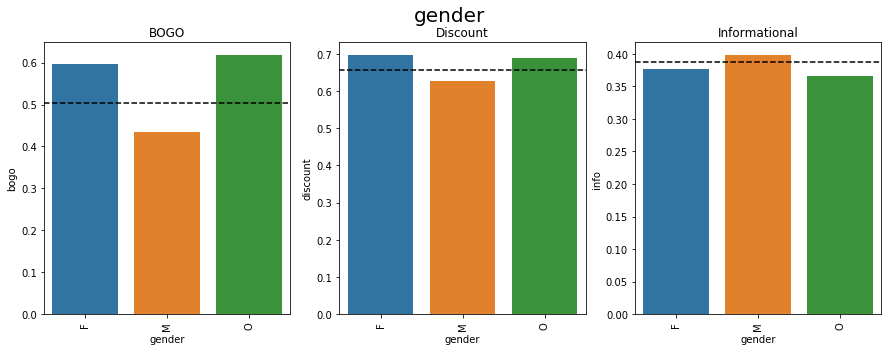

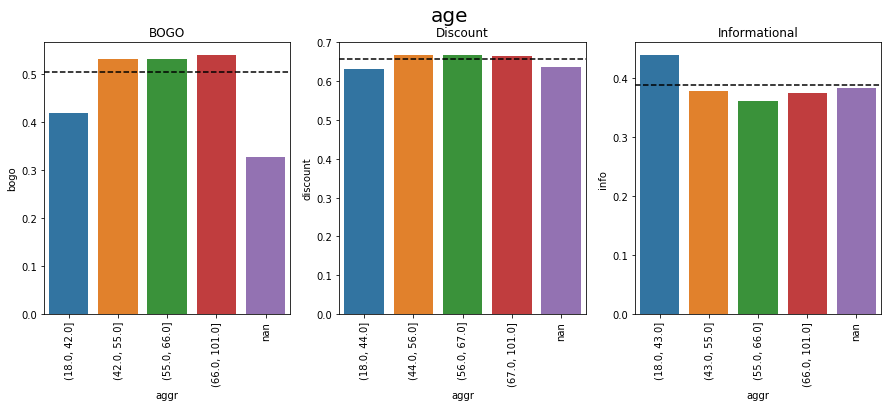

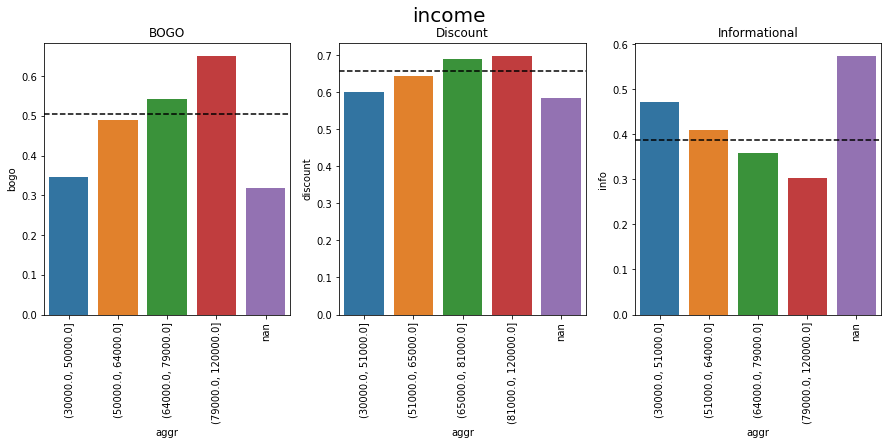

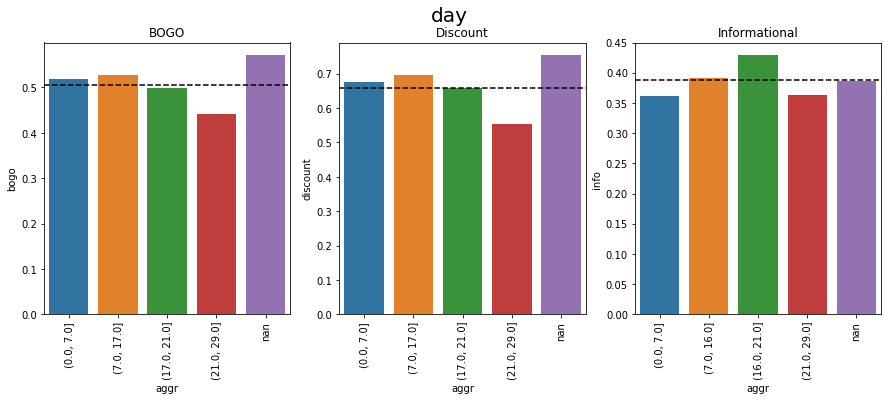

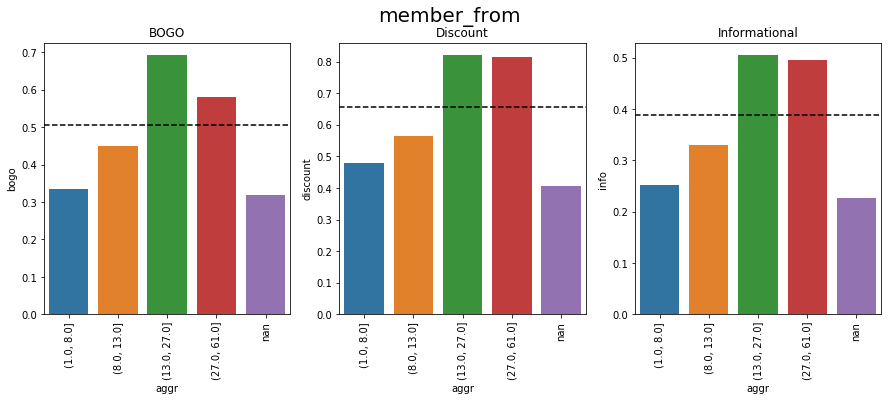

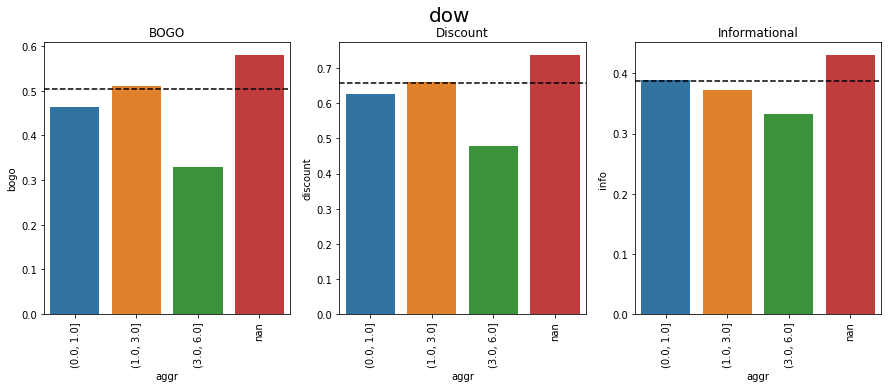

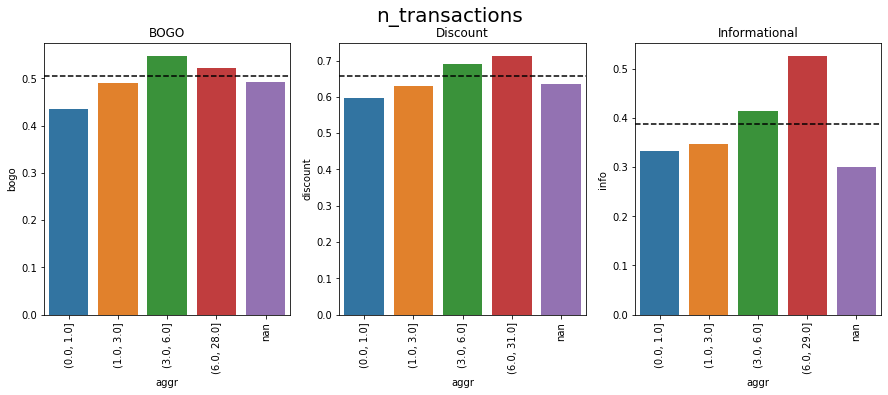

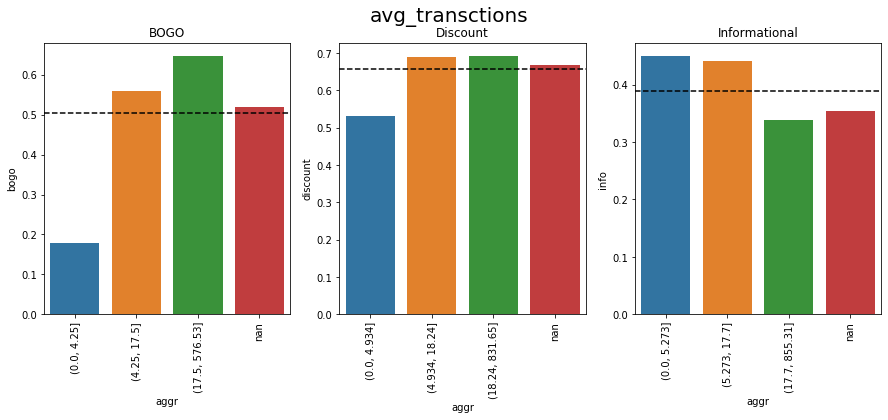

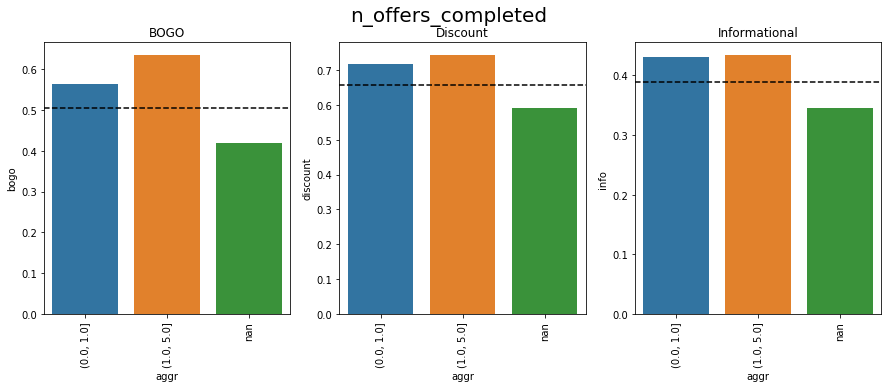

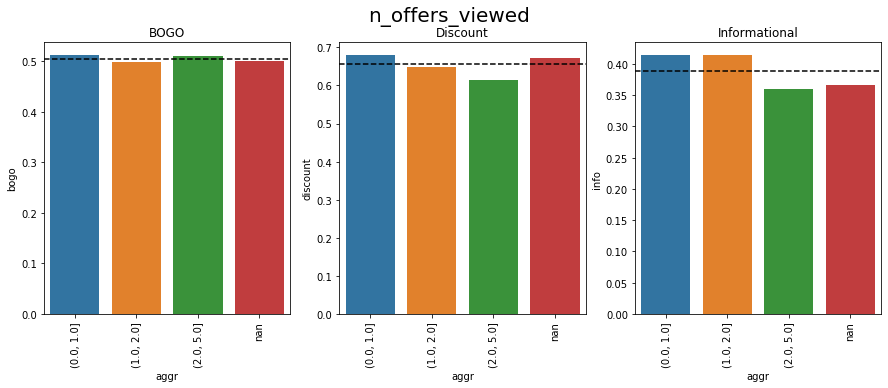

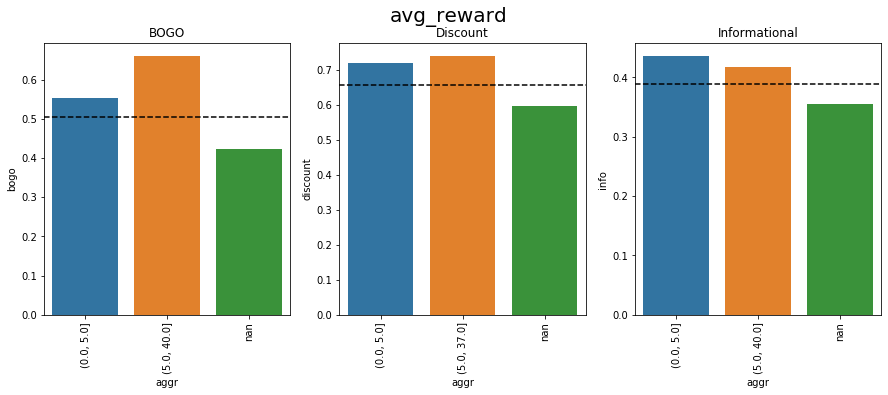

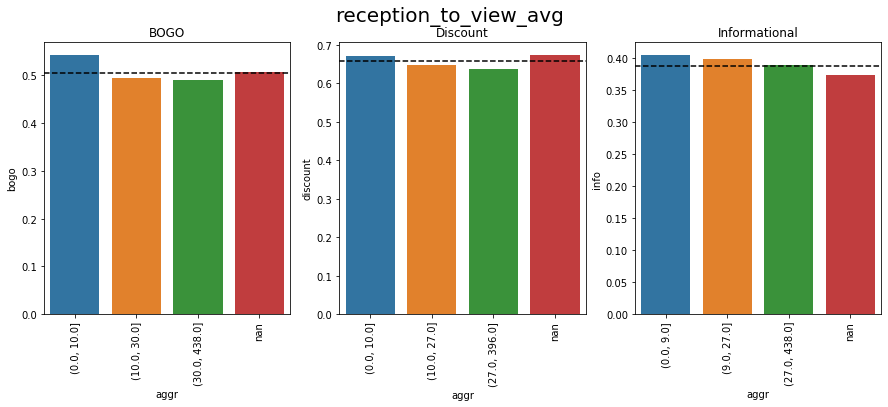

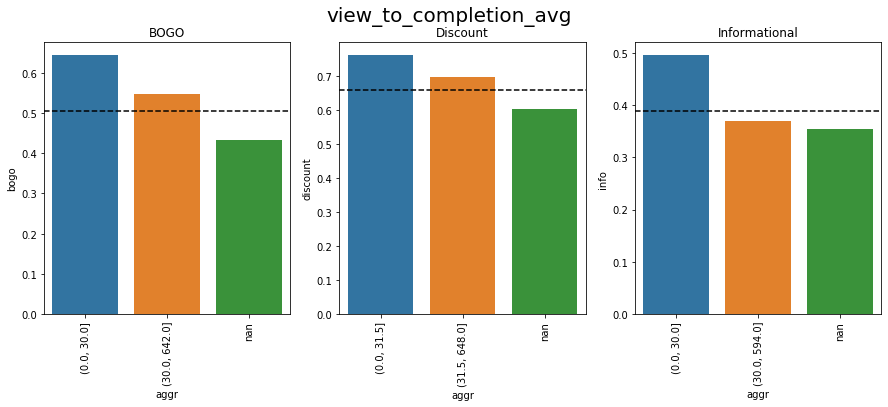

In [24]:
for feature in keep_vars:
    analyse_var(feature)